# Applying XGBoost to the Prima Indian Diabetes dataset

In [262]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt
%matplotlib inline

In [263]:
df = pd.read_csv('diabetes.csv')

In [264]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Check data types - XGBoost only takes int, float & boolean

In [265]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [266]:
X = df.drop('Outcome', axis=1).copy()
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [267]:
y = df['Outcome'].copy()
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

<br>
<br>
Find how evenly distributed the data is by adding all the positive cases represented by '1' by the total number of cases.<br>
Only 35% of positive cases. <br> 
Stratify the data during train-test split.

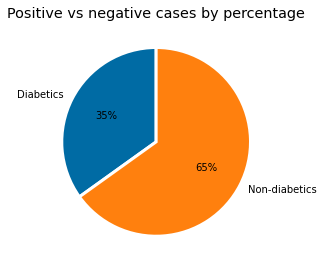

In [268]:
chart_data = [sum(y)/len(y), 1-(sum(y)/len(y))]
plt.style.use('tableau-colorblind10')
plt.title("Positive vs negative cases by percentage")
plt.tight_layout()
plt.pie(chart_data, labels=["Diabetics", "Non-diabetics"], wedgeprops={'edgecolor':"white", "linewidth":3}, startangle=90, autopct='%1.0f%%')
plt.show()

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [270]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None)
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.64939
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.66856
[2]	validation_0-aucpr:0.65668
[3]	validation_0-aucpr:0.66085
[4]	validation_0-aucpr:0.67238
[5]	validation_0-aucpr:0.69549
[6]	validation_0-aucpr:0.69260
[7]	validation_0-aucpr:0.69622
[8]	validation_0-aucpr:0.68900
[9]	validation_0-aucpr:0.67696
[10]	validation_0-aucpr:0.67459
[11]	validation_0-aucpr:0.67040
[12]	validation_0-aucpr:0.65950
[13]	validation_0-aucpr:0.64842
[14]	validation_0-aucpr:0.65110
[15]	validation_0-aucpr:0.65115
[16]	validation_0-aucpr:0.65520
[17]	validation_0-aucpr:0.65614
Stopping. Best iteration:
[7]	validation_0-aucpr:0.69622



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

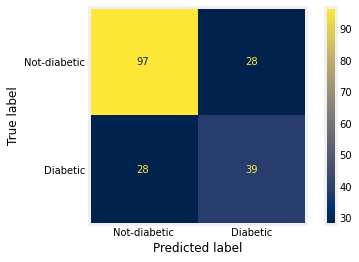

In [271]:
plot_confusion_matrix(clf_xgb, X_test, y_test, display_labels=["Not-diabetic", "Diabetic"], cmap='cividis')
plt.grid(False)

Of the 125 (103 + 22) people who are not diabetic, the algorithm correctly classified 103 **(82.4%)** as non-diabetic (True Negative)<br>
Of the 67 (27 + 40) people who are diabetic, the algorithm correctly classified 40 **(60%)** as diabetic (True Positive)<br>
Conclusion: a little better than a coin-toss to predict diabetes. 

In [272]:
from sklearn.metrics import accuracy_score
y_pred = clf_xgb.predict(X_test) 
print(accuracy_score(y_test, y_pred))

0.7083333333333334


## Optimise Hyper-parameters to get better results

### Round 1

In [273]:
param_grid = {
    'max_depth': [3,4,5],
    'learning_rate':[0.1, 0.01, 0.05],
    'gamma':[0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1,3,5]
    }

In [274]:
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', subsample=0.9, colsample_bytree=0.5), param_grid=param_grid, scoring='roc_auc', verbose=0, n_jobs=10, cv=10)

In [275]:
optimal_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric = 'auc', eval_set=[(X_test, y_test)], verbose=False)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=0.9,
                                     tree_method=None, 

In [276]:
print(optimal_params.best_params_)

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 10.0, 'scale_pos_weight': 1}


### Round 2

* gamma is in the middle - do not change gamma value 
* Learning rate on the edge - reduce learning rate
* Max depth on the edge - reduce max depth
* re_lambda in the middle - do not change
* scale_pos_weight is on edge - reduce

In [277]:
param_grid2 = {
    'max_depth': [1,2,3],
    'learning_rate':[0.05, 0.001, 0.0001],
    'gamma':[0.25],
    'reg_lambda': [1.0],
    'scale_pos_weight': [0.25,0.5,1]
    }

In [278]:
optimal_params2 = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', subsample=0.9, colsample_bytree=0.5), param_grid=param_grid2, scoring='roc_auc', verbose=0, n_jobs=10, cv=10)

In [279]:
optimal_params2.fit(X_train, y_train, early_stopping_rounds=10, eval_metric = 'auc', eval_set=[(X_test, y_test)], verbose=False)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=0.9,
                                     tree_method=None, 

In [280]:
print(optimal_params2.best_params_)

{'gamma': 0.25, 'learning_rate': 0.0001, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 1}


## Final version

In [281]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', gamma = 0.25, learning_rate = 0.05, max_depth = 3, reg_lambda = 1.0, scale_pos_weight = 1, subsample = 0.9, colsample_bytree = 0.5)

In [282]:
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric=['auc'], eval_set=[(X_test,y_test)])
#,'error','logloss'

[0]	validation_0-auc:0.71552
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.80561
[2]	validation_0-auc:0.82400
[3]	validation_0-auc:0.80890
[4]	validation_0-auc:0.81397
[5]	validation_0-auc:0.81463
[6]	validation_0-auc:0.80943
[7]	validation_0-auc:0.80776
[8]	validation_0-auc:0.80591
[9]	validation_0-auc:0.80424
[10]	validation_0-auc:0.80406
[11]	validation_0-auc:0.80239
[12]	validation_0-auc:0.80484
Stopping. Best iteration:
[2]	validation_0-auc:0.82400



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

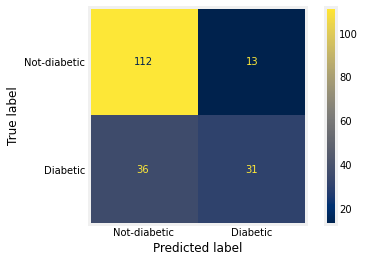

In [283]:
plot_confusion_matrix(clf_xgb, X_test, y_test, display_labels=["Not-diabetic", "Diabetic"], cmap='cividis')
plt.grid(False)

In [286]:
y_pred = clf_xgb.predict(X_test) 
print(accuracy_score(y_test, y_pred))

0.7447916666666666


In [285]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.90      0.82       125
           1       0.70      0.46      0.56        67

    accuracy                           0.74       192
   macro avg       0.73      0.68      0.69       192
weighted avg       0.74      0.74      0.73       192

